In [1]:
# 15m 收在下布林，且下影線大於實體Ｋ及上影線
# ! conda install -c conda-forge ta --yes
# ! conda update -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1672543585000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)

    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low     Volume
0     2023-01-01 11:44:59  1193.39  1194.00  1194.00  1193.17   923.9797
1     2023-01-01 11:59:59  1194.00  1194.04  1194.39  1193.75   884.4465
2     2023-01-01 12:14:59  1194.05  1192.64  1194.05  1192.63  1580.2392
3     2023-01-01 12:29:59  1192.63  1192.18  1192.85  1190.57  3052.2194
4     2023-01-01 12:44:59  1192.18  1192.04  1192.93  1192.03   742.6090
...                   ...      ...      ...      ...      ...        ...
7393  2023-03-19 11:59:59  1778.31  1782.52  1784.91  1777.91  4085.0613
7394  2023-03-19 12:14:59  1782.51  1781.19  1786.65  1780.45  3401.6337
7395  2023-03-19 12:29:59  1781.18  1777.08  1782.59  1775.64  3474.0722
7396  2023-03-19 12:44:59  1777.08  1779.59  1780.50  1776.38  2044.1599
7397  2023-03-19 12:59:59  1779.59  1778.28  1780.70  1778.28   484.6769

[7398 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
#     ema
    ema_int = 200
    df['ema'] = ta.trend.ema_indicator(df.Close, window=ema_int)
    return df

In [8]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema
0,2023-01-01 11:44:59,1193.39,1194.00,1194.00,1193.17,923.9797,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01 11:59:59,1194.00,1194.04,1194.39,1193.75,884.4465,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-01 12:14:59,1194.05,1192.64,1194.05,1192.63,1580.2392,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-01 12:29:59,1192.63,1192.18,1192.85,1190.57,3052.2194,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-01 12:44:59,1192.18,1192.04,1192.93,1192.03,742.6090,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7393,2023-03-19 11:59:59,1778.31,1782.52,1784.91,1777.91,4085.0613,1776.237333,1794.905114,1776.237333,1757.569553,54.626788,1763.718242
7394,2023-03-19 12:14:59,1782.51,1781.19,1786.65,1780.45,3401.6337,1775.756333,1793.098173,1775.756333,1758.414494,53.072708,1763.892090
7395,2023-03-19 12:29:59,1781.18,1777.08,1782.59,1775.64,3474.0722,1775.311667,1791.789298,1775.311667,1758.834035,48.482546,1764.023313
7396,2023-03-19 12:44:59,1777.08,1779.59,1780.50,1776.38,2044.1599,1774.934000,1790.454944,1774.934000,1759.413056,51.255236,1764.178206


In [9]:
def conditions(df):

    # c1 下影線 大於 實體Ｋ & 下影線 大於 上影線
    # c1_1 紅Ｋ
    # c1_2 綠Ｋ
    # c2 收盤 小於 布林下
    # c3 > 200ema

    for index, row in df.iterrows():
        # c1 red candle
        df['c1_1'] = (abs(df['Low'] - df['Close']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Close']) > abs(df['High'] - df['Open']))
        # c1 green candle
        df['c1_2'] = (abs(df['Low'] - df['Open']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Open']) > abs(df['High'] - df['Close']))
        # c2
        df['c2'] = df['Close'] < df['bb_l']
        # c3
        df['c3'] = df['Close'] >= df['ema']

    # 條件達成
    df['signal'] = False
    df.loc[(df['c1_1'] | df['c1_2']) & df.c2 & df.c3, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema,c1_1,c1_2,c2,c3,signal,openbuy
0,2023-01-01 11:44:59,1193.39,1194.00,1194.00,1193.17,923.9797,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False
1,2023-01-01 11:59:59,1194.00,1194.04,1194.39,1193.75,884.4465,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
2,2023-01-01 12:14:59,1194.05,1192.64,1194.05,1192.63,1580.2392,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,False
3,2023-01-01 12:29:59,1192.63,1192.18,1192.85,1190.57,3052.2194,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False,False
4,2023-01-01 12:44:59,1192.18,1192.04,1192.93,1192.03,742.6090,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,2023-03-19 11:59:59,1778.31,1782.52,1784.91,1777.91,4085.0613,1776.237333,1794.905114,1776.237333,1757.569553,54.626788,1763.718242,False,False,False,True,False,False
7394,2023-03-19 12:14:59,1782.51,1781.19,1786.65,1780.45,3401.6337,1775.756333,1793.098173,1775.756333,1758.414494,53.072708,1763.892090,False,False,False,True,False,False
7395,2023-03-19 12:29:59,1781.18,1777.08,1782.59,1775.64,3474.0722,1775.311667,1791.789298,1775.311667,1758.834035,48.482546,1764.023313,False,True,False,True,False,False
7396,2023-03-19 12:44:59,1777.08,1779.59,1780.50,1776.38,2044.1599,1774.934000,1790.454944,1774.934000,1759.413056,51.255236,1764.178206,False,False,False,True,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    elif buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


               Close_Time     Open    Close     High      Low      Volume  \
334   2023-01-04 23:14:59  1250.94  1248.13  1253.35  1241.89  20755.3418   
335   2023-01-04 23:29:59  1248.13  1250.32  1251.05  1248.13   3724.5583   
337   2023-01-04 23:59:59  1253.35  1255.88  1258.09  1253.34   6344.3373   
396   2023-01-05 14:44:59  1251.65  1251.00  1252.07  1249.16   4416.1436   
397   2023-01-05 14:59:59  1250.99  1250.97  1251.86  1250.73   1407.1927   
...                   ...      ...      ...      ...      ...         ...   
7351  2023-03-19 01:29:59  1787.13  1773.00  1787.90  1771.82   7971.2789   
7352  2023-03-19 01:44:59  1773.00  1778.08  1778.91  1762.22  12710.3322   
7372  2023-03-19 06:44:59  1779.59  1764.94  1780.23  1763.72   5749.9366   
7373  2023-03-19 06:59:59  1764.93  1769.18  1772.97  1763.28   8881.8461   
7375  2023-03-19 07:29:59  1770.52  1754.98  1773.78  1754.01   6899.7682   

              sma         bb_u         bb_m         bb_l  ...          ema 

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)


result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per]}

result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low          sma  \
0    2023-01-04 23:29:59  1248.13  1250.32  1251.05  1248.13  1251.125333   
1    2023-01-04 23:59:59  1253.35  1255.88  1258.09  1253.34  1251.337333   
2    2023-01-05 14:59:59  1250.99  1250.97  1251.86  1250.73  1253.917333   
3    2023-01-05 15:29:59  1250.73  1248.50  1250.73  1247.48  1253.452333   
4    2023-01-05 15:44:59  1248.50  1249.83  1250.09  1248.49  1253.197000   
..                   ...      ...      ...      ...      ...          ...   
106  2023-03-19 00:44:59  1773.23  1786.70  1789.13  1747.47  1808.589667   
107  2023-03-19 01:44:59  1773.00  1778.08  1778.91  1762.22  1804.920333   
108  2023-03-19 06:44:59  1779.59  1764.94  1780.23  1763.72  1786.362000   
109  2023-03-19 06:59:59  1764.93  1769.18  1772.97  1763.28  1785.348000   
110  2023-03-19 07:29:59  1770.52  1754.98  1773.78  1754.01  1784.018333   

            bb_u         bb_l        rsi position  entry_p  stop_loss  size

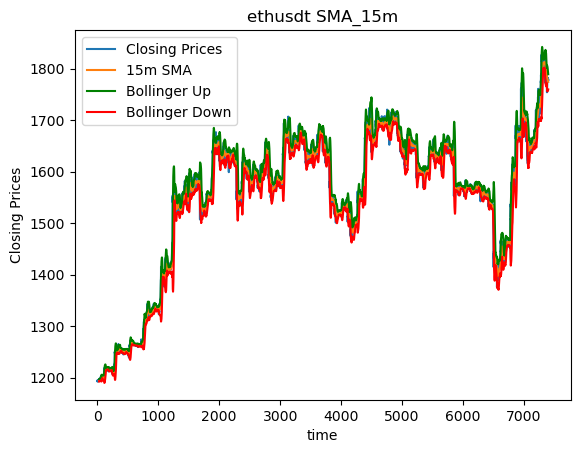

In [13]:
plt.title(symbol + ' SMA_' + str(interval))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(interval) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()